In [1]:
''' Import libraries '''
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from IPython.display import display

1920 1080
image len:  1137


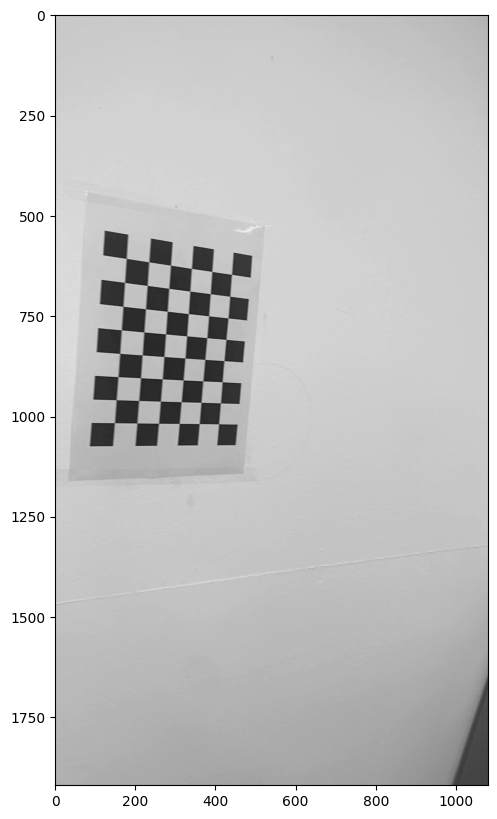

In [4]:
''' Load image using OpenCV '''
# Upload the LMS image to Google Drive and point to its location.
# Note OpenCV reads image as BGR.
image_directory = '/home/phw93/dev/calib/data/*.jpg'
image_files = glob.glob(image_directory)
image_files = sorted(image_files)
images = []
for image_file in image_files:
    image = cv2.imread(image_file)
    images.append(image)

images_len = len(images)
# Normalize image to between 0 and 1.
img = cv2.cvtColor(images[10], cv2.COLOR_BGR2GRAY).astype(float) / 255.0
w, h = img.shape
print(w, h)
print("image len: ", images_len)
# Show output
plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')
plt.show()

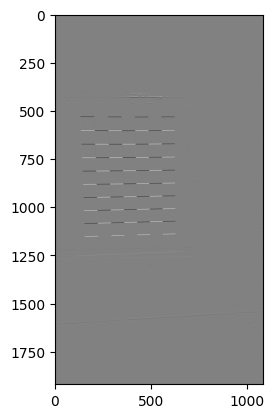

In [55]:
# Perform Sobel filtering along the x-axis.
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Ix = cv2.filter2D(img, -1, sobel_x)

# Perform Sobel filtering along the y-axis.
''' DO IT YOURSELF for Iy '''
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
Iy = cv2.filter2D(img, -1, sobel_y)

# plt.imshow(Ix, cmap='gray')
plt.imshow(Iy, cmap='gray')


In [56]:
''' Approximate local error surface '''
window_size = 3
offset = int(np.floor(window_size/2)) 

det = np.zeros(img.shape)
trace = np.zeros(img.shape)

# For each pixel in image
for y in range(offset, img.shape[0]-offset):
  for x in range(offset, img.shape[1]-offset):
    
    # Build ROI window around the current pixel
    # Note numpy uses height-by-width convention (row x column)
    window_x = Ix[y-offset:y+offset+1, x-offset:x+offset+1]
    ''' DO IT YOURSELF for window_y '''
    window_y = Iy[y-offset:y+offset+1, x-offset:x+offset+1]
    

    # Estimate elements of matrix M.
    Sxx = np.sum(window_x * window_x)
    ''' DO IT YOURSELF for Syy and Sxy '''
    Syy = np.sum(window_y * window_y)
    Sxy = np.sum(window_x * window_y)

    # Compute determinant of M and trace of M.
    # Note numpy uses height-by-width convention (row x column)
    trace[y,x] = Sxx + Syy
    ''' DO IT YOURSELF for det[y,x] '''
    det[y,x] = Sxx*Syy - Sxy**2

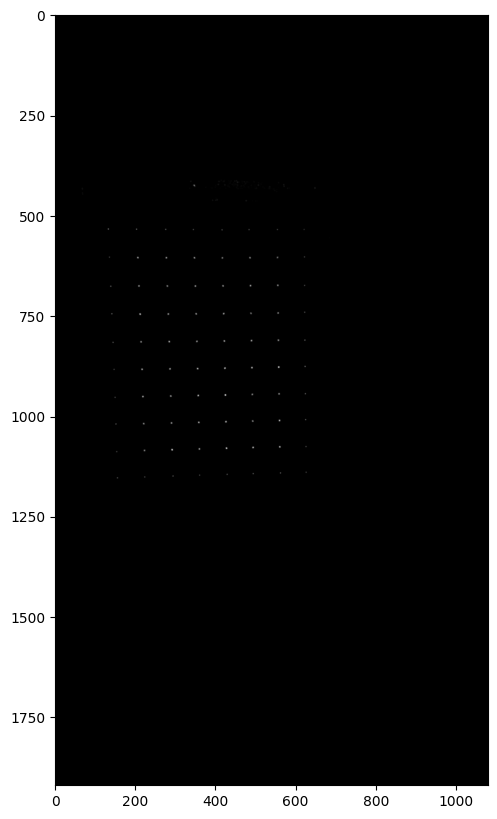

In [57]:
# Set hyperparameters
alpha = 0.04
beta = 0.01

# Compute response map
''' DO IT YOURSELF!: R - det(M) - alpha * trace(M)^2 '''
R = np.zeros(img.shape)
for y in range(offset, img.shape[0]-offset):
  for x in range(offset, img.shape[1]-offset):
    R[y,x] = det[y,x] - alpha * (trace[y,x]**2)
    max_R = 0
    
    if max_R < R[y,x]:
      max_R = R[y,x]
# max_R = np.argmax(R)
# print(max_R)
# Use thresholding to discard responses with low amplitude
''' DO IT YOURSELF! R is discarded if R < beta * max(R) '''
for y in range(offset, img.shape[0]-offset):
  for x in range(offset, img.shape[1]-offset):
    if R[y,x] < beta * max_R:
      R[y,x] = 0.0
# Smooth the response map using Gaussian filter
''' DO IT YOURSELF! Define gaussian_2d kernel as a numpy array. '''
gaussian_2d = np.array([[1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16]])
R = cv2.filter2D(R, -1, gaussian_2d)

# Show the response map
plt.figure(figsize=(10, 10))
plt.imshow(R, cmap='gray')
plt.show()


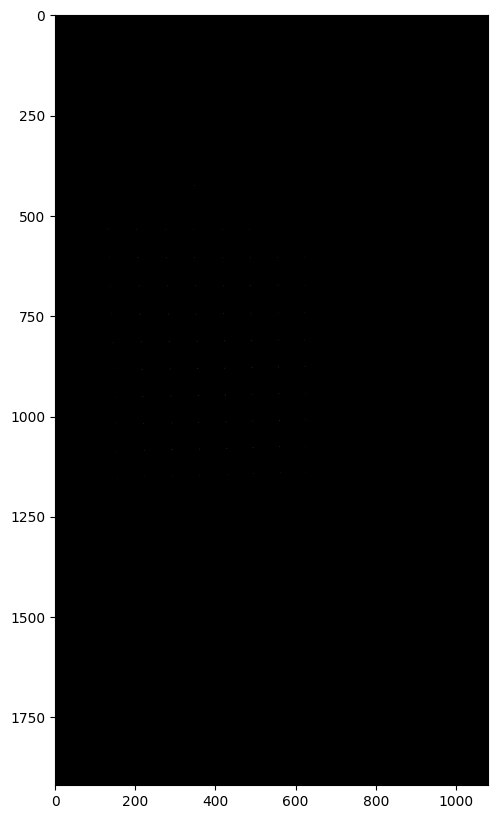

In [58]:
# Set NMS window size
window_size = 15
offset = int(np.floor(window_size/2))
output_img = np.zeros(img.shape)
features = set()
# For each pixel, perform non-maximal suppression around it in 3x3 block.
for y in range(offset, img.shape[0]-offset):
  for x in range(offset, img.shape[1]-offset):
    
    if R[y,x] == 0.0:
      # If the response map value is 0, then we can skip
      continue
    center_value = R[y,x]
    max_value = -100.0
    for m in range(y-offset, y+offset+1):
      for n in range(x-offset, x+offset+1):
        if max_value < R[m,n]:
          max_value = R[m,n]

    # If the center value is not the same as the maximum value of the 3x3 block, 
    # then it's not maximum, so suppress.
    # Otherwise, let the pixel survive.
    if center_value != max_value:
      R[y,x] = 0
      output_img[y,x] = R[y,x]
    else:
      output_img[y,x] = R[y,x]

plt.figure(figsize=(10, 10))
plt.imshow(R, cmap='gray')
plt.show()

80
(132, 533)
(135, 603)
(138, 676)
(141, 744)
(144, 816)
(147, 883)
(149, 953)
(151, 1019)
(153, 1088)
(155, 1154)
(202, 534)
(206, 604)
(209, 675)
(211, 745)
(214, 814)
(216, 883)
(218, 951)
(220, 1018)
(222, 1085)
(223, 1151)
(275, 534)
(277, 605)
(279, 675)
(282, 745)
(284, 814)
(286, 882)
(288, 950)
(290, 1017)
(291, 1083)
(293, 1149)
(344, 534)
(346, 424)
(347, 605)
(349, 675)
(351, 745)
(353, 813)
(354, 881)
(356, 948)
(357, 1015)
(359, 1082)
(359, 1147)
(415, 535)
(416, 605)
(418, 675)
(419, 744)
(421, 812)
(422, 880)
(424, 947)
(425, 1014)
(427, 1080)
(428, 1145)
(482, 535)
(485, 605)
(486, 674)
(487, 743)
(489, 811)
(490, 879)
(490, 946)
(492, 1012)
(492, 1078)
(493, 1143)
(553, 534)
(553, 604)
(554, 673)
(555, 743)
(555, 810)
(556, 877)
(557, 944)
(558, 1011)
(559, 1076)
(561, 1141)
(620, 603)
(621, 674)
(621, 741)
(621, 810)
(622, 876)
(623, 944)
(623, 1008)
(624, 1076)
(624, 1140)


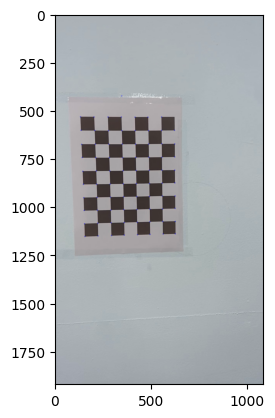

In [59]:
''' Extract feature points and draw on the image '''
while()
y, x = np.where(output_img>25.0)

print(len(x)) # ideal 80
for i in range(0, len(x)):
  features.add((x[i], y[i]))
  output_vis = cv2.circle(img_bgr, (x[i], y[i]), 3, (0, 0, 255))
plt.imshow(output_vis, cmap='gray')

features_vec = list(features)
sorted_features = sorted(features_vec)
for pts in sorted_features:
  print(pts)